# Setup

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import skew, kurtosis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Membuat dataframe data csv

df1 = pd.read_csv("Dataset1_TranscriptMahasiswa.csv", sep=";", dtype={"NIM" :"object", "NAMA_MK" : "string"})
df2 = pd.read_csv("Dataset2_EvaluasiDosenPerMK.csv", sep=";", decimal=",")

In [4]:
# Banyak Mahasiswa
print('Ada', df1["NIM"].nunique(), 'Mahasiswa')

Ada 770 Mahasiswa


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30870 entries, 0 to 30869
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NIM       30870 non-null  object 
 1   ANGKATAN  30870 non-null  int64  
 2   SEMESTER  30870 non-null  int64  
 3   KODE_MK   30870 non-null  object 
 4   NAMA_MK   30847 non-null  string 
 5   SKS       30870 non-null  int64  
 6   NILAI     30858 non-null  float64
 7   GRADE     30318 non-null  object 
dtypes: float64(1), int64(3), object(3), string(1)
memory usage: 1.9+ MB


Ada Nama_MK, Nilai, dan Grade yang null

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TAHUN       2114 non-null   int64  
 1   SEMESTER    2114 non-null   int64  
 2   MATAKULIAH  2114 non-null   object 
 3   PERTANYAAN  2114 non-null   int64  
 4   KETERANGAN  2114 non-null   object 
 5   NILAI       2114 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 99.2+ KB


Tidak ada data null

# Data Cleansing

### Dataframe 1 (Transkrip Mahasiswa)

In [8]:
# check null tiap kolom df1

df1.isnull().any()

NIM         False
ANGKATAN    False
SEMESTER    False
KODE_MK     False
NAMA_MK      True
SKS         False
NILAI        True
GRADE        True
dtype: bool

<AxesSubplot:>

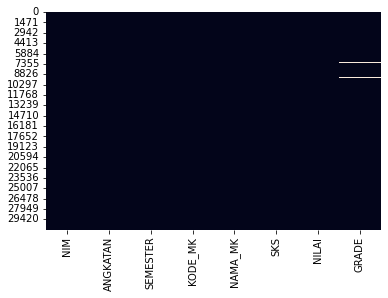

In [6]:
sns.heatmap(df1.isnull(), cbar=False)

In [10]:
# check Kode_MK dari Nama_MK yang null
df1['KODE_MK'][df1['NAMA_MK'].isnull()].unique()

array(['SI863'], dtype=object)

In [11]:
df1["SEMESTER"].unique()

array([1011, 1021, 1111, 1121, 1211, 1221, 1311, 1321, 1322, 1122, 1222,
       1411, 1421, 1022, 1422, 1511, 1621, 1521, 1611, 1711, 1721, 1722,
       1522, 1821, 1811, 1622, 1822, 1911])

In [12]:
# fill Nama_MK yang null

df1["NAMA_MK"] = df1["NAMA_MK"].fillna("Tugas Akhir") # Kebetulan yang null cuman SI863

# add kode MK ke Nama_MK

for i in df1.index:  
    if df1.at[i, "KODE_MK"] not in df1.at[i, "NAMA_MK"].split(" ") : 
        df1.at[i, "NAMA_MK"] = df1.at[i, "KODE_MK"] + " " + df1.at[i, "NAMA_MK"]

In [13]:
indeks = ["A", "A-", "B+", "B", "B-", "C+", "C", "D", "E", "F"]
bobot = [4, 3.7, 3.3, 3.0, 2.7, 2.3, 2.0, 1.0, 0, 0]
ranges = [[100, 85], [84.99, 80], [79.99, 75], [74.99, 70], [69.99, 65], [64.99, 60], [59.99, 55], [54.99, 45], [44.99,0]]

# fill grade yang null

for i in df1.index:
    for j in ranges:
        if j[1] <= df1.at[i, "NILAI"] <= j[0]:
            df1.at[i, "GRADE"] = indeks[ranges.index(j)]

# menambah total bobot = bobot x sks

for i in df1.index:
    for j in indeks:
        if df1.at[i, "GRADE"] == j:
            df1.at[i, "BOBOT"] = bobot[indeks.index(j)]
            df1.at[i, "TOTAL_BOBOT"] = df1.at[i, "BOBOT"] * df1.at[i, "SKS"]

In [11]:
df1.head()

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
0,10110310002,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,57.0,C,2.0,6.0
1,10110310002,2010,1011,EM180,EM180 Matematika Bisnis,3,70.0,B,3.0,9.0
2,10110310002,2010,1011,TI100,TI100 Algoritma dan Pemrograman,4,57.0,C,2.0,8.0
3,10110310002,2010,1011,TI101,TI101 Matematika Diskrit,3,59.0,C,2.0,6.0
4,10110310002,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B,3.0,9.0


In [14]:
# re-check null pada kolom GRADE

df1[df1['GRADE'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [15]:
# check kolom NILAI yang null

df1[df1['NILAI'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
18866,00000009931,2015,1811,IS341,IS341 Sistem Basis Data,3,NaN,F,0.0,0.0
21965,00000012407,2015,1621,IS432,IS432 Pengantar E-Business,3,NaN,F,0.0,0.0
22633,00000013019,2016,1821,IS670,IS670 Audit Sistem Informasi,3,NaN,F,0.0,0.0
25920,00000019365,2017,1811,IS341,IS341 Sistem Basis Data,3,NaN,F,0.0,0.0
26030,00000019601,2017,1721,IS201,IS201 Proses Bisnis Korporat,3,NaN,F,0.0,0.0
26760,00000021116,2017,1711,IF110,IF110 Pengantar Teknologi Multimedia,3,NaN,F,0.0,0.0
26901,00000021159,2017,1821,UM321,UM321 Bahasa Inggris 3,2,NaN,F,0.0,0.0
27520,00000022742,2017,1721,IS230,IS230 Algoritma dan Pemrograman,3,NaN,F,0.0,0.0
27774,00000023564,2017,1721,IS230,IS230 Algoritma dan Pemrograman,3,NaN,F,0.0,0.0
29423,00000028446,2018,1821,IS220,IS220 Interaksi Manusia dan Komputer,3,NaN,F,0.0,0.0


Semua NILAI null berasal dari GRADE F \
Oleh karena GRADE F berarti nilainya 0, kolom NILAI akan diisi dengan angka 0

In [16]:
# fill null pada kolom NILAI

df1["NILAI"] = df1["NILAI"].fillna(0)
df1[df1['NILAI'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [17]:
# check nim yang duplicate mk

def checkDuplicate():
    nim_mhs = df1['NIM'].unique()
    nim_for_doubled = []

    for nim in nim_mhs:
        dummy_df1 = df1.loc[df1['NIM'] == nim]
        if dummy_df1['NAMA_MK'].duplicated().any():
            nim_for_doubled.append(nim)
            
    return nim_for_doubled

In [18]:
checkDuplicate()

['10110310011',
 '10110310022',
 '10110310036',
 '10110310037',
 '10110310044',
 '10110310045',
 '10110310047',
 '10110310083',
 '11110310003',
 '11110310004',
 '11110310005',
 '11110310009',
 '11110310020',
 '11110310026',
 '11110310035',
 '11110310080',
 '13110310069']

In [19]:
print(f'Ada {len(checkDuplicate())} mahasiswa yang mengambil suatu mata kuliah secara berulang')

Ada 17 mahasiswa yang mengambil suatu mata kuliah secara berulang


In [20]:
# drop Mata Kuliah yang berulang dan menyimpan mata kuliah terakhir kali diambil

df1 = df1.drop_duplicates(subset=['KODE_MK', 'NIM'], keep='last')

In [21]:
print(f'Setelah drop duplicates, ada {len(checkDuplicate())} mahasiswa yang mengambil suatu mata kuliah secara berulang')

Setelah drop duplicates, ada 0 mahasiswa yang mengambil suatu mata kuliah secara berulang


In [22]:
df1["KODE_MK"].unique()

array(['EM100', 'EM180', 'TI100', 'TI101', 'TI110', 'UM121', 'UM151',
       'EM201', 'IK402', 'SI200', 'SI214', 'TI220', 'UM141', 'UM160',
       'UM222', 'EM372', 'SI301', 'SI302', 'SI750', 'SK304', 'TI330',
       'EM604', 'SI420', 'SI426', 'SI431', 'SK430', 'TI403', 'EA100',
       'SI511', 'SI520', 'SI521', 'SI522', 'SI527', 'TI532', 'EA410',
       'SI415', 'SI612', 'SI624', 'SI628', 'SI661', 'SI664', 'SI210',
       'SI723', 'SI725', 'SI729', 'SI860', 'SI863', 'TI751', 'SI325',
       'SI541', 'SI642', 'SI744', 'IS761', 'IS862', 'SI643', 'SI745',
       'IF635', 'IS230', 'IS645', 'IF140', 'IS110', 'IS251', 'IS321',
       'IS624', 'UM142', 'UM122', 'UM152', 'IS302', 'IS432', 'UM321',
       'IS853', 'IS534', 'IS341', 'SK533', 'SK632', 'SK733', 'IS403',
       'IS670', 'EA201', 'UM223', 'EM190', 'IS623', 'IS660', 'IS422',
       'IS543', 'IS725', 'CE441', 'IS652', 'IS431', 'IS442', 'IS681',
       'IS727', 'IS782', 'IS250', 'IS513', 'UM162', 'IS342', 'IS240',
       'IS726', 'CE5

### Dataframe 2 (Evaluasi Dosen per Mata Kuliah) 

In [23]:
# check null tiap kolom df2

df2.isnull().any()

TAHUN         False
SEMESTER      False
MATAKULIAH    False
PERTANYAAN    False
KETERANGAN    False
NILAI         False
dtype: bool

<AxesSubplot:>

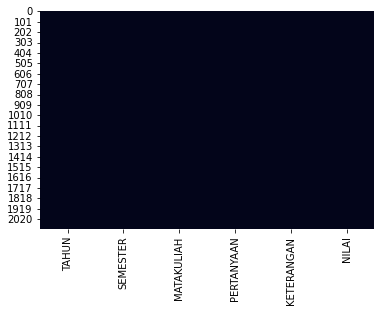

In [21]:
sns.heatmap(df2.isnull(), cbar=False)

In [24]:
for i in df2.index:  
    df2.at[i,"KODE_MK"] = df2.at[i, "MATAKULIAH"].split(" ")[0]  
df2.head(14)

,TAHUN,SEMESTER,MATAKULIAH,PERTANYAAN,KETERANGAN,NILAI,KODE_MK
0,2015,1511,IS100 Management Information Systems,1,Kesiapan memberikan perkuliahan/praktikum,3.28,IS100
1,2015,1511,IS100 Management Information Systems,2,Upaya menyampaikan materi perkuliahan/praktik...,3.25,IS100
2,2015,1511,IS100 Management Information Systems,3,Sistematis dalam menyampaikan materi perkuliah...,3.24,IS100
3,2015,1511,IS100 Management Information Systems,4,Kemampuan memberikan contoh yang relevan dari ...,3.30,IS100
4,2015,1511,IS100 Management Information Systems,5,Penyampaian materi perkuliahan sesuai dengan k...,3.27,IS100
5,2015,1511,IS100 Management Information Systems,6,Pemakaian buku teks sebagai buku utama perkuli...,3.19,IS100
6,2015,1511,IS100 Management Information Systems,7,Memberi review materi perkuliahan sebelumnya,3.18,IS100
7,2015,1511,IS100 Management Information Systems,8,"Pemberian kesempatan bertanya, berdiskusi sert...",3.32,IS100
8,2015,1511,IS100 Management Information Systems,9,Kejelasan menjawab pertanyaan /diskusi di kelas,3.29,IS100
9,2015,1511,IS100 Management Information Systems,10,Pemberian tugas/kuis serta pembahasannya di kelas,3.24,IS100


In [25]:
# nilai rata-rata dari tiap matakuliah

df4 = pd.DataFrame(df2.groupby(["TAHUN", "MATAKULIAH", "SEMESTER", "KODE_MK"])["NILAI"].mean().reset_index())
df4.rename(columns = {"MATAKULIAH" : "NAMA_MK","NILAI" : "NILAI_RATA-RATA"}, inplace = True)

# Exploratory Data Analysis (EDA)

### EDA Dataframe 1 (Transkrip Mahasiswa)

In [26]:
# statistika deskripsi

df1[['NILAI']].describe()

,NILAI
count,30085.000000
mean,74.263321
std,15.751127
min,0.000000
25%,66.000000
50%,74.000000
75%,85.000000
max,100.000000


Text(0, 0.5, 'Jumlah')

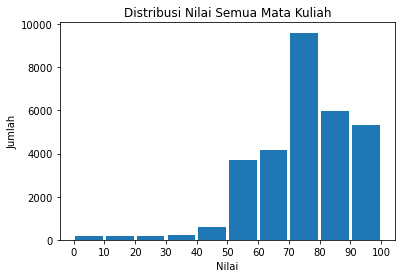

In [27]:
# distribusi nilai mata kuliah

plt.title("Distribusi Nilai Semua Mata Kuliah")
plt.hist(df1["NILAI"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], rwidth=0.9)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel("Nilai")
plt.ylabel("Jumlah")

<AxesSubplot:xlabel='NILAI', ylabel='Count'>

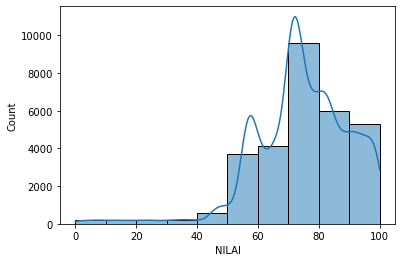

In [28]:
sns.histplot(data=df1, x='NILAI', bins=10, kde=True)

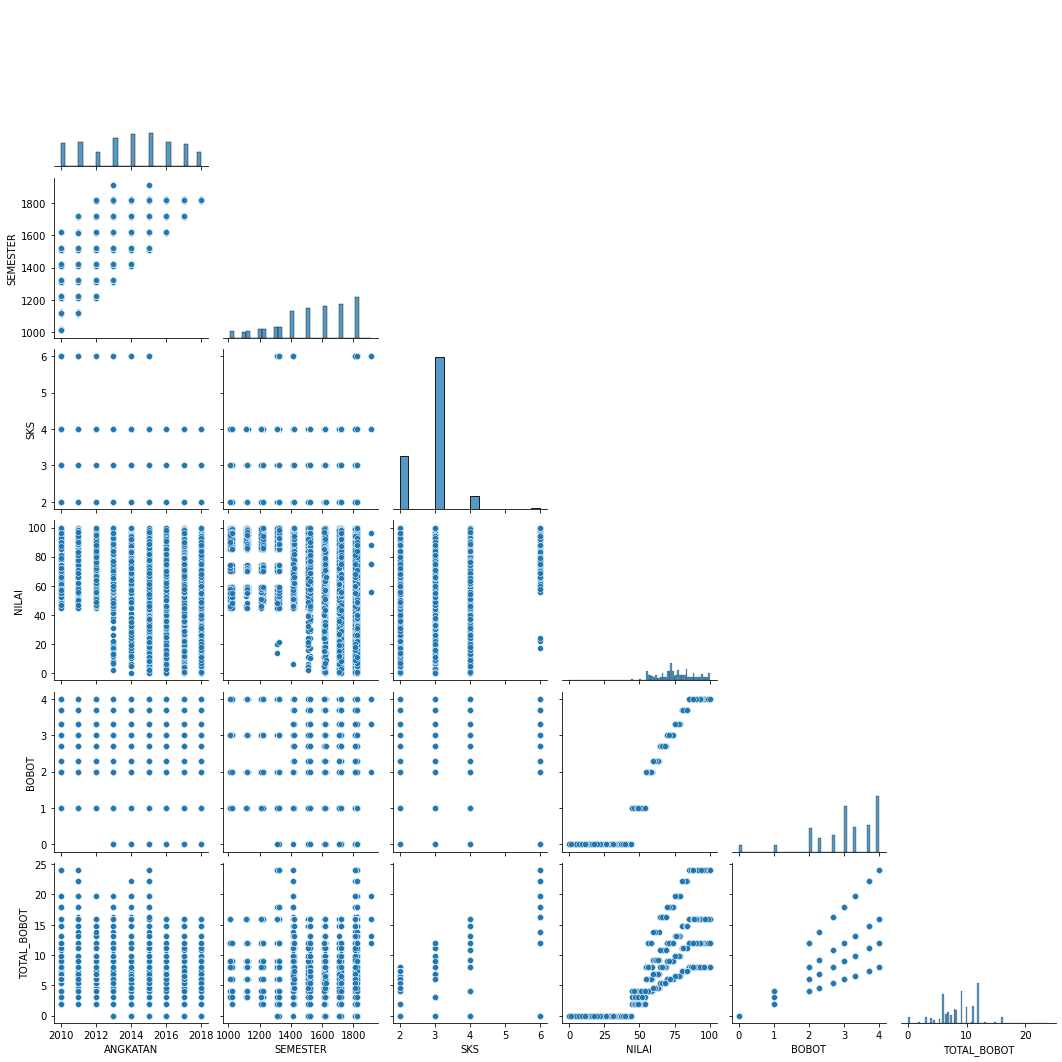

In [29]:
# check hubungan linier

sns.pairplot(data=df1, corner=True)

Berdasarkan plot di atas, antar kolom pada data Transkrip Mahasiswa tidak memiliki hubungan linier

### EDA Dataframe 3 (Transkrip Mahasiswa tiap NIM)

In [30]:
# Pembuataan Dataframe dengan grouping data berdasarkan NIM

# Perhitungan SKS
df3_ = pd.DataFrame(df1.groupby(["NIM"])["SKS"].sum().reset_index())

# Perhitungan Grade
df3__ = pd.DataFrame(df1.loc[(df1["GRADE"] == "D") | (df1["GRADE"] == "E") | (df1["GRADE"] == "F")].groupby("NIM")["GRADE"].sum().reset_index())

# Perhitungan Total Bobot
df3___ = pd.DataFrame((df1.groupby("NIM")["TOTAL_BOBOT"].sum().reset_index()))

# Perhitungan jumlah semester
df3____ =  pd.DataFrame((((df1.groupby("NIM")["SEMESTER"].max() - df1.groupby("NIM")["SEMESTER"].min()) / 100).reset_index()))


# Penambahan Kolom Lulus Tepat Waktu 

# Merging Dataframe
df3 = pd.merge(df3_, df3__, how="left", on=["NIM"])
df3 = pd.merge(df3, df3___, how="left", on=["NIM"])
df3 = pd.merge(df3, df3____, how="left", on=["NIM"])
df3["GRADE"] = df3["GRADE"].fillna("")

df3.rename(columns = {"GRADE" : "FAILED_GRADE", "SKS" : "TOTAL_SKS", "SEMESTER" : "WAKTU_KULIAH"}, inplace = True)

# Perhitungan IPK
for i in df3.index:
    df3.at[i ,"IPK"] = df3.at[i, "TOTAL_BOBOT"] / df3.at[i, "TOTAL_SKS"]
    if df3.at[i, "WAKTU_KULIAH"] - int(df3.at[i, "WAKTU_KULIAH"]) != 0: 
        df3.at[i, "WAKTU_KULIAH"] = int(df3.at[i, "WAKTU_KULIAH"]) + 0.5
df3.head()

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK
0,00000008429,145,D,474.5,3.5,3.272414
1,00000008455,136,DD,416.2,3.5,3.060294
2,00000008481,127,DDDEEED,313.6,3.5,2.469291
3,00000008631,145,,519.3,3.0,3.581379
4,00000008684,145,,512.1,3.0,3.531724


In [31]:
# df1.loc[df1["NIM"] == '10110310011']
df3.loc[df3["TOTAL_SKS"] > 150]

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK


In [32]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 769
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NIM           770 non-null    object 
 1   TOTAL_SKS     770 non-null    int64  
 2   FAILED_GRADE  770 non-null    object 
 3   TOTAL_BOBOT   770 non-null    float64
 4   WAKTU_KULIAH  770 non-null    float64
 5   IPK           770 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 58.3+ KB


In [33]:
# Belum Nambah Faktor yang ngulang terus nilainya udah lulus 

# Kolom :
# Hasil : TIDAK LULUS, LULUS, TEPAT WAKTU

for i in df3.index:
    if df3.at[i, "TOTAL_SKS"] >= 144 and df3.at[i, "FAILED_GRADE"] == "" and df3.at[i, "IPK"] >= 2.5:
        # if df3.at[i, "WAKTU_KULIAH"] <= 4:
        #     df3.at[i, "HASIL"] = "Lulus Tepat Waktu"
        # else: 
        #     df3.at[i, "HASIL"] = "Lulus Telat"
        df3.at[i, "HASIL"] = "Lulus"
    else:  
        df3.at[i, "HASIL"] = "Tidak Lulus"

In [34]:
# check waktu kuliah untuk ketepatan waktu lulus kuliah mahasiswa

df3["WAKTU_KULIAH"].unique()

array([3.5, 3. , 4. , 2.5, 1.5, 0.5, 4.5, 5. , 6. , 6.5, 5.5])

In [35]:
# check mahasiswa yang telah kuliah 4 tahun atau lebih

df3.loc[(df3["WAKTU_KULIAH"] >= 4)]

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,HASIL
14,00000009318,145,D,469.4,4.0,3.237241,Tidak Lulus
37,00000010495,146,DD,422.6,4.0,2.894521,Tidak Lulus
71,00000011774,145,D,481.8,4.0,3.322759,Tidak Lulus
433,10110310004,145,DD,420.6,4.5,2.900690,Tidak Lulus
437,10110310008,145,D,412.0,4.5,2.841379,Tidak Lulus
...,...,...,...,...,...,...,...
765,14110310095,145,DD,469.9,4.0,3.240690,Tidak Lulus
766,14110310098,145,D,464.1,4.0,3.200690,Tidak Lulus
767,14110310101,138,,438.4,4.5,3.176812,Tidak Lulus
768,14110310102,133,EEE,362.2,4.5,2.723308,Tidak Lulus


In [36]:
# statistika deskriptif df3

df3.describe()

,TOTAL_SKS,TOTAL_BOBOT,WAKTU_KULIAH,IPK
count,770.000000,770.000000,770.000000,770.000000
mean,110.763636,337.295714,2.716234,2.943970
std,41.083773,153.354122,1.437582,0.608181
min,40.000000,0.000000,0.500000,0.000000
25%,82.000000,193.625000,1.500000,2.673277
50%,134.000000,395.850000,3.500000,3.034729
75%,145.000000,463.875000,3.500000,3.340000
max,148.000000,580.000000,6.500000,4.000000


In [37]:
df3["HASIL"].value_counts()

Tidak Lulus    589
Lulus          181
Name: HASIL, dtype: int64

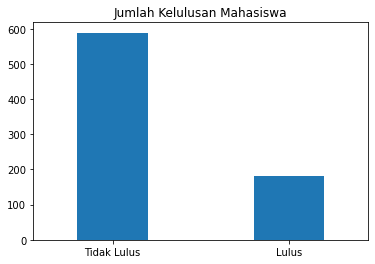

In [56]:
# plot kelulusan mahasiswa

df3["HASIL"].value_counts().plot(kind='bar', width=0.4)
plt.xticks(rotation=0)
plt.title('Jumlah Kelulusan Mahasiswa')
plt.show()

Berdasarkan plot kelulusan mahasiswa, masih banyak mahasiswa yang belum lulus dibandingkan yang dapat lulus. \
Oleh karena itu, data mahasiswa ini tidak seimbang untuk pemodelan.

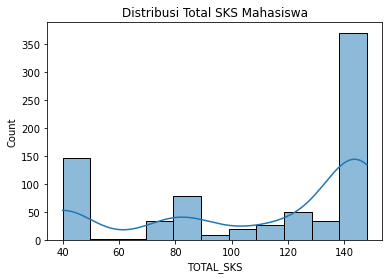

In [57]:
# histogram/distribusi total sks

sns.histplot(data=df3, x='TOTAL_SKS', kde=True)
plt.title('Distribusi Total SKS Mahasiswa')
plt.show()

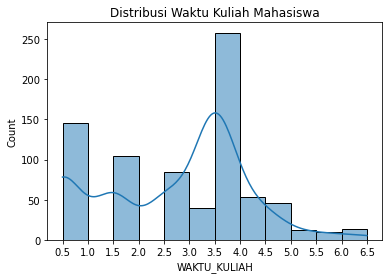

In [58]:
# histogram/distribusi waktu kuliah

bin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
sns.histplot(data=df3, x='WAKTU_KULIAH', bins=bin, kde=True)
plt.xticks(bin)
plt.title('Distribusi Waktu Kuliah Mahasiswa')
plt.show()

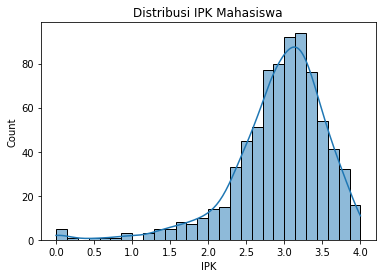

In [56]:
# histogram/distribusi ipk

sns.histplot(data=df3, x='IPK', kde=True)
plt.title('Distribusi IPK Mahasiswa')
plt.show()

In [59]:
print('IPK Skewness:', skew(df3['IPK']))
print('IPK Kurtosis:', kurtosis(df3['IPK']))

IPK Skewness: -1.5035917059355945
IPK Kurtosis: 4.178268491050808


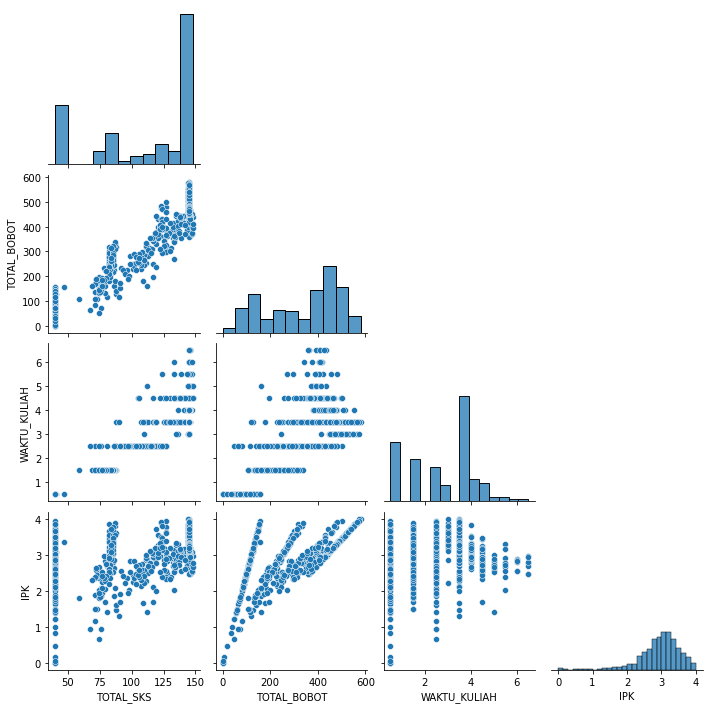

In [60]:
# check hubungan linier df3

sns.pairplot(data=df3, corner=True)

Berdasarkan plot di atas, antar kolom pada dataframe 3 tidak memiliki hubungan linier

### EDA Dataframe 2 (Evaluasi Dosen per Mata Kuliah)

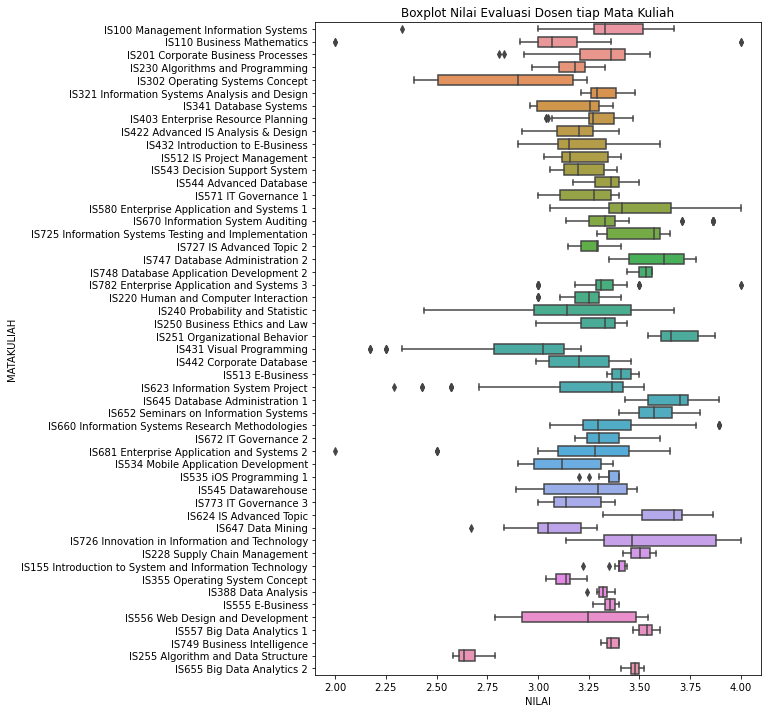

In [61]:
# boxplot evaluasi nilai per matkul

plt.figure(figsize=(8,12))
sns.boxplot(x='NILAI', y='MATAKULIAH', data=df2)
plt.title('Boxplot Nilai Evaluasi Dosen tiap Mata Kuliah')
plt.show()

Berdasarkan plot di atas, dosen mata kuliah Algorithm and Data Structure memiliki penilaian yang cenderung kecil dibandingkan mata kuliah lainnya.

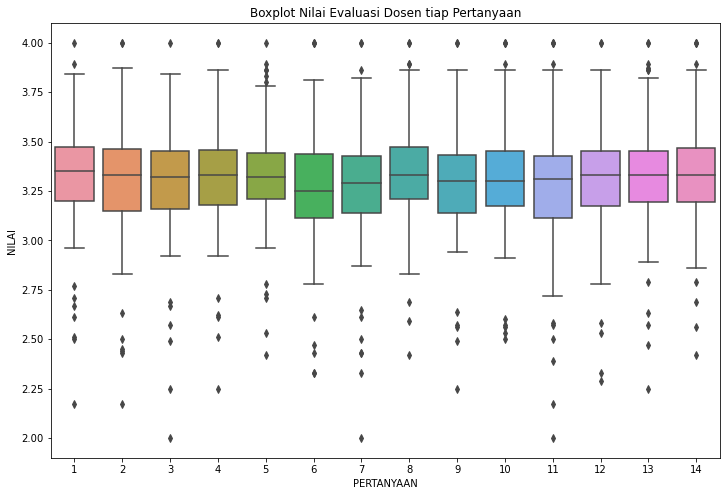

In [62]:
# boxplot evaluasi nilai dosen per pertanyaan

plt.figure(figsize=(12,8))
sns.boxplot(x='PERTANYAAN', y='NILAI', data=df2)
plt.title('Boxplot Nilai Evaluasi Dosen tiap Pertanyaan')
plt.show()

Berdasarkan plot di atas, tiap pertanyaan mengenai evaluasi dosen memiliki rata-rata nilai yang cenderugn sama

In [63]:
# Rata-rata penilaian dosen per tahun

df2_d = df2.groupby('TAHUN')['NILAI'].mean().reset_index()
df2_d

,TAHUN,NILAI
0,2015,3.269231
1,2016,3.267432
2,2017,3.363956
3,2018,3.351299


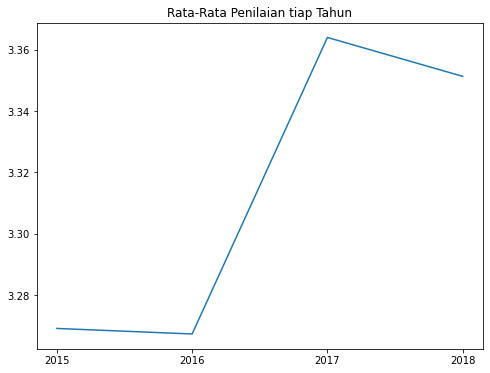

In [64]:
# plot rata-rata nilai evaluasi dosen per tahun

plt.figure(figsize=(8,6))
plt.plot(df2_d['TAHUN'], df2_d['NILAI'])
plt.title('Rata-Rata Penilaian tiap Tahun')
plt.xticks(df2_d['TAHUN'])
plt.show()

Overall naik \
Penilaian dosen meningkat pesat dari 2016 ke 2017 \
Ada penurunan sekitar 0.01 dari 2017 ke 2018

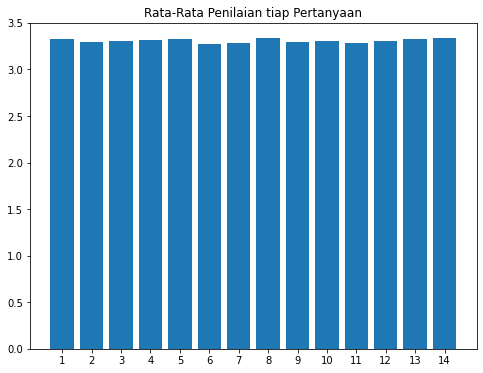

In [62]:
df2_dd = df2.groupby('PERTANYAAN')['NILAI'].mean().reset_index()

plt.figure(figsize=(8,6))
plt.bar(df2_dd['PERTANYAAN'], df2_dd['NILAI'])
plt.title('Rata-Rata Penilaian tiap Pertanyaan')
plt.xticks(df2_dd['PERTANYAAN'])
plt.show()

Text(0.5, 1.0, 'Rata-Rata Penilaian Tahunan tiap Pertanyaan')

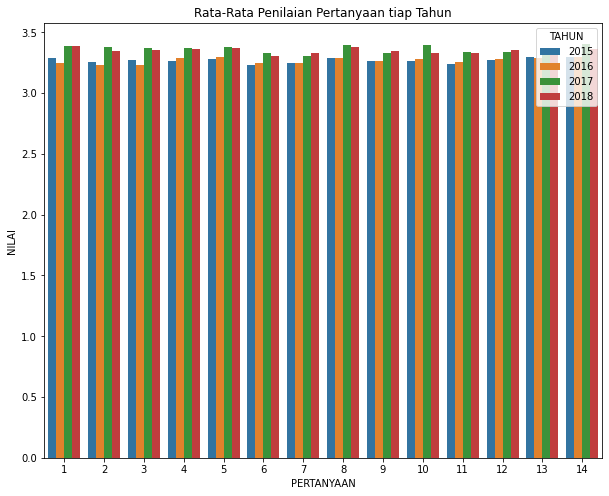

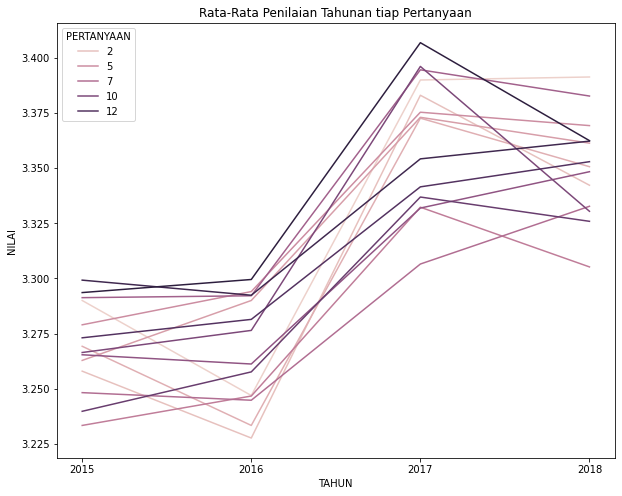

In [63]:
df2_ddd = df2.groupby(['TAHUN', 'PERTANYAAN'])['NILAI'].mean().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='PERTANYAAN', y='NILAI', data=df2_ddd, hue='TAHUN')
plt.title('Rata-Rata Penilaian Pertanyaan tiap Tahun')

plt.figure(figsize=(10,8))
sns.lineplot(x='TAHUN', y='NILAI', data=df2_ddd, hue='PERTANYAAN')
plt.xticks([2015, 2016, 2017, 2018])
plt.title('Rata-Rata Penilaian Tahunan tiap Pertanyaan')

Tiap pertanyaan memiliki rataan penilaian yang meningkat pesat dari 2016 ke 2017 \
Berarti secara rata-rata, dosen memiliki kinerja yang lebih baik, terlebih lagi dari 2015 ke 2016 banyak penurunan

Yok cari insights nya :'))

<Figure size 720x1080 with 0 Axes>

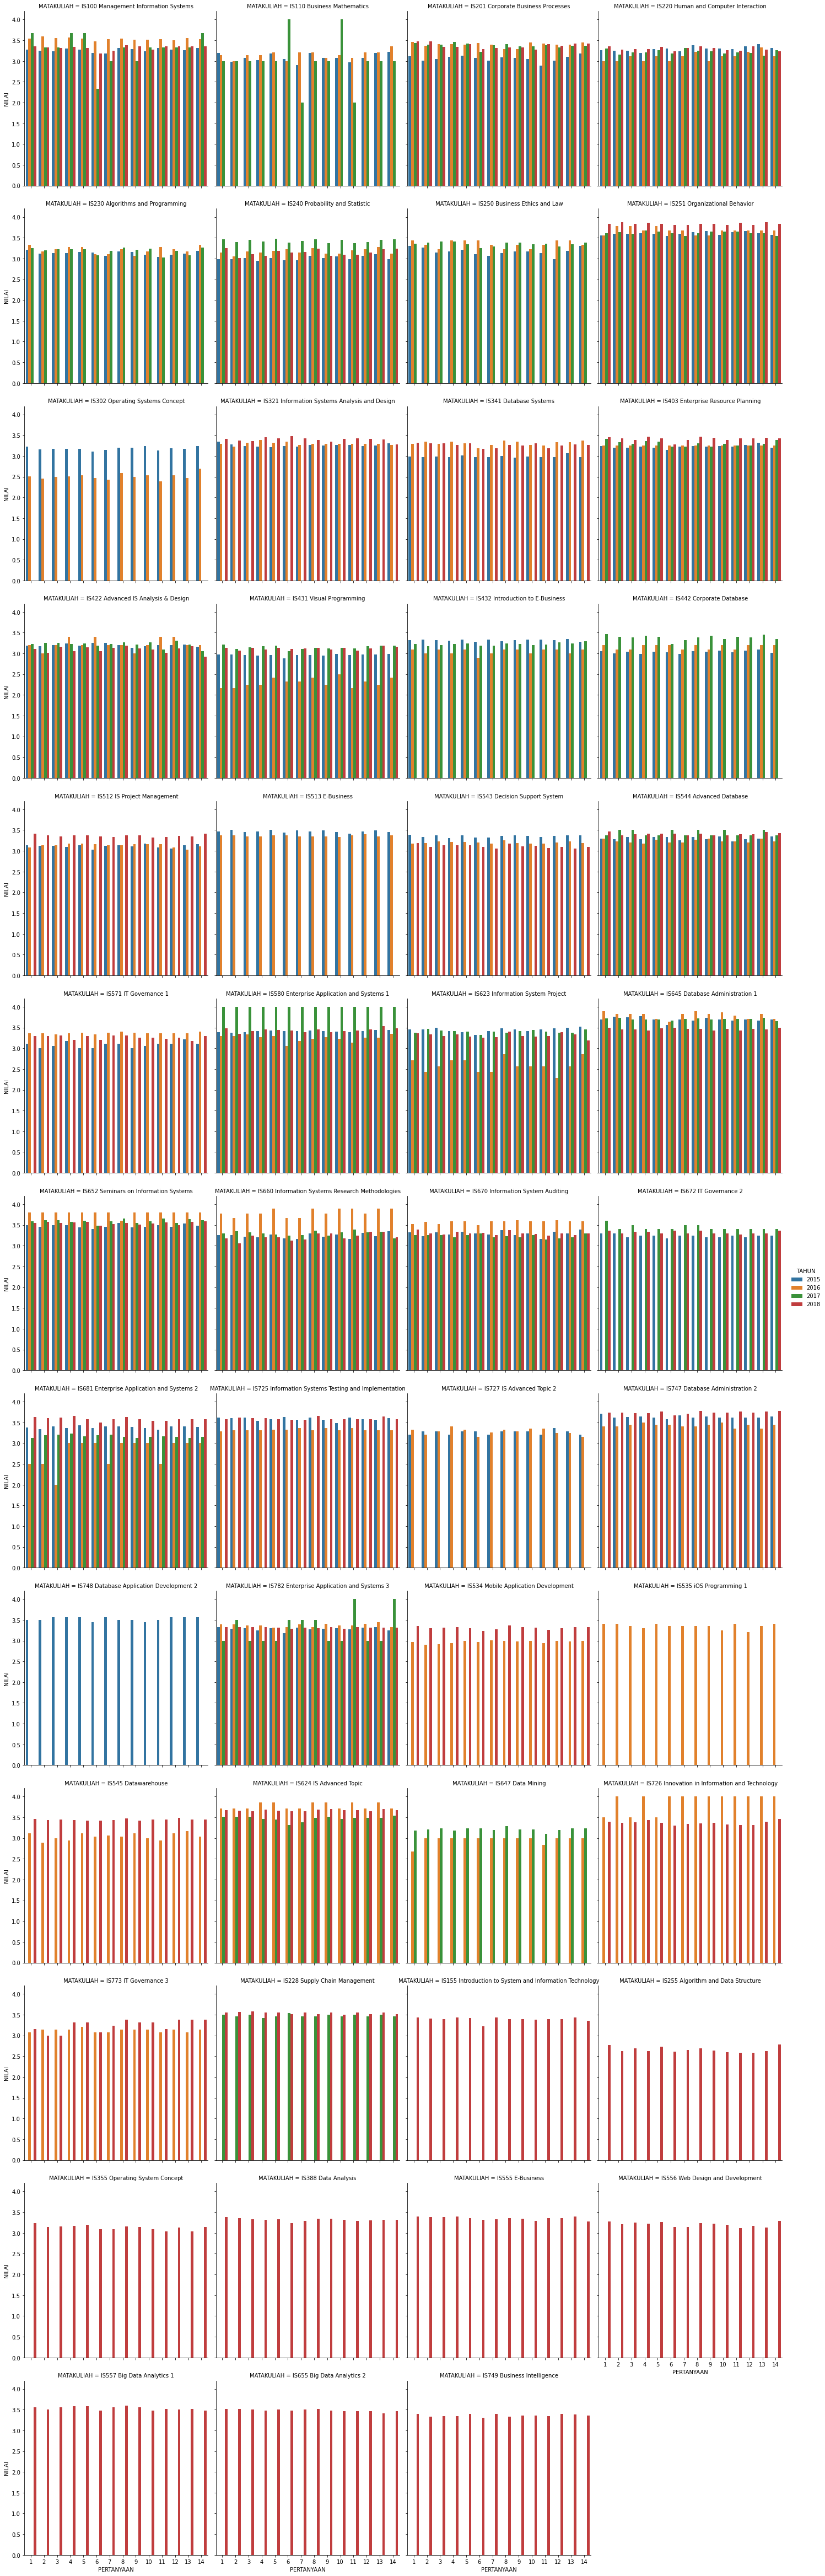

In [64]:
df2_ddde = df2.groupby(['TAHUN', 'MATAKULIAH', 'PERTANYAAN'])['NILAI'].mean().reset_index()

plt.figure(figsize=(10,15))
sns.catplot(x='PERTANYAAN', y='NILAI', data=df2_ddde, hue='TAHUN', kind='bar', col='MATAKULIAH', col_wrap=4)

In [ ]:
df2_ddde.tail()

,TAHUN,MATAKULIAH,PERTANYAAN,NILAI
1941,2018,IS782 Enterprise Application and Systems 3,10,3.29
1942,2018,IS782 Enterprise Application and Systems 3,11,3.32
1943,2018,IS782 Enterprise Application and Systems 3,12,3.31
1944,2018,IS782 Enterprise Application and Systems 3,13,3.31
1945,2018,IS782 Enterprise Application and Systems 3,14,3.31


### EDA df1 + df2 

In [26]:
df1.head()

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
0,10110310002,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,57.0,C,2.0,6.0
1,10110310002,2010,1011,EM180,EM180 Matematika Bisnis,3,70.0,B,3.0,9.0
2,10110310002,2010,1011,TI100,TI100 Algoritma dan Pemrograman,4,57.0,C,2.0,8.0
3,10110310002,2010,1011,TI101,TI101 Matematika Diskrit,3,59.0,C,2.0,6.0
4,10110310002,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B,3.0,9.0


In [27]:
df4

,TAHUN,NAMA_MK,SEMESTER,KODE_MK,NILAI_RATA-RATA
0,2015,IS100 Management Information Systems,1511,IS100,3.265000
1,2015,IS110 Business Mathematics,1511,IS110,3.087143
2,2015,IS201 Corporate Business Processes,1511,IS201,3.170000
3,2015,IS201 Corporate Business Processes,1521,IS201,2.958571
4,2015,IS220 Human and Computer Interaction,1521,IS220,3.295000
...,...,...,...,...,...
146,2018,IS726 Innovation in Information and Technology,1821,IS726,3.455714
147,2018,IS747 Database Administration 2,1811,IS747,3.740000
148,2018,IS749 Business Intelligence,1811,IS749,3.361429
149,2018,IS773 IT Governance 3,1811,IS773,3.240714


In [28]:
df4

,TAHUN,NAMA_MK,SEMESTER,KODE_MK,NILAI_RATA-RATA
0,2015,IS100 Management Information Systems,1511,IS100,3.265000
1,2015,IS110 Business Mathematics,1511,IS110,3.087143
2,2015,IS201 Corporate Business Processes,1511,IS201,3.170000
3,2015,IS201 Corporate Business Processes,1521,IS201,2.958571
4,2015,IS220 Human and Computer Interaction,1521,IS220,3.295000
...,...,...,...,...,...
146,2018,IS726 Innovation in Information and Technology,1821,IS726,3.455714
147,2018,IS747 Database Administration 2,1811,IS747,3.740000
148,2018,IS749 Business Intelligence,1811,IS749,3.361429
149,2018,IS773 IT Governance 3,1811,IS773,3.240714


In [29]:
# Banyaknya mahasiswa yang lulus pada masing-masing mata kuliah tiap semesternya

df1_ = pd.DataFrame(df1.groupby(["KODE_MK", "SEMESTER", "GRADE"]).size().reset_index())
df1_.rename(columns = {0 : "TOTAL"}, inplace = True)
df1_.head() 

,KODE_MK,SEMESTER,GRADE,TOTAL
0,CE441,1421,A,2
1,CE441,1421,A-,7
2,CE441,1421,B,10
3,CE441,1421,B+,3
4,CE441,1421,B-,7


In [30]:
for i in df4.index: 
    lulus = 0
    tidak_lulus = 0
    for j in df1_.index:
        if df4.at[i, "KODE_MK"] == df1_.at[j, "KODE_MK"] and df4.at[i, "SEMESTER"] == df1_.at[j, "SEMESTER"]:
            if df1_.at[j, "GRADE"] == "D" or df1_.at[j, "GRADE"] == "E" or df1_.at[j, "GRADE"] == "F":
                tidak_lulus += df1_.at[j, "TOTAL"]
            else: 
                lulus += df1_.at[j, "TOTAL"]
    df4.at[i, "LULUS"] = lulus  
    df4.at[i, "TIDAK_LULUS"] = tidak_lulus  
    for k in df2.index:
        if df4.at[i, "KODE_MK"] == df2.at[k, "KODE_MK"] and df4.at[i, "SEMESTER"] == df2.at[k, "SEMESTER"]:
            df4.at[i, df2.at[k, "PERTANYAAN"]] = df2.at[k, "NILAI"] 
    

In [31]:
df4["PROPORSI_LULUS"] = df4["LULUS"] / (df4["LULUS"] + df4["TIDAK_LULUS"])  
df4.head()

,TAHUN,NAMA_MK,SEMESTER,KODE_MK,NILAI_RATA-RATA,LULUS,TIDAK_LULUS,1,2,3,...,6,7,8,9,10,11,12,13,14,PROPORSI_LULUS
0,2015,IS100 Management Information Systems,1511,IS100,3.265000,99.0,4.0,3.28,3.25,3.24,...,3.19,3.18,3.32,3.29,3.24,3.31,3.27,3.26,3.31,0.961165
1,2015,IS110 Business Mathematics,1511,IS110,3.087143,76.0,18.0,3.19,2.98,3.08,...,3.05,2.91,3.20,3.07,3.07,2.97,3.08,3.19,3.22,0.808511
2,2015,IS201 Corporate Business Processes,1511,IS201,3.170000,2.0,1.0,3.27,3.18,3.16,...,3.20,3.02,3.20,3.14,3.14,2.98,3.09,3.20,3.33,0.666667
3,2015,IS201 Corporate Business Processes,1521,IS201,2.958571,61.0,6.0,2.96,2.83,2.93,...,2.96,3.01,2.99,3.00,2.96,2.81,2.93,3.00,3.04,0.910448
4,2015,IS220 Human and Computer Interaction,1521,IS220,3.295000,96.0,0.0,3.26,3.25,3.25,...,3.30,3.23,3.38,3.30,3.30,3.29,3.35,3.41,3.32,1.000000


In [32]:
df4.loc[(df4["LULUS"] == 0) & (df4["TIDAK_LULUS"] == 0)]

,TAHUN,NAMA_MK,SEMESTER,KODE_MK,NILAI_RATA-RATA,LULUS,TIDAK_LULUS,1,2,3,...,6,7,8,9,10,11,12,13,14,PROPORSI_LULUS
37,2015,IS748 Database Application Development 2,1511,IS748,3.521429,0.0,0.0,3.5,3.5,3.56,...,3.44,3.56,3.5,3.5,3.44,3.5,3.56,3.56,3.56,NaN


In [33]:
# Tidak ada yang pernah mengambil mata kuliah dengan kode IS748
df1.loc[df1["KODE_MK"] == "IS748"]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [34]:
# membuang data untuk kode IS748
df4 = df4.dropna()

Correlation : 0.34080563254288343


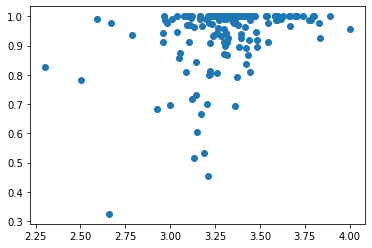

In [36]:
plt.scatter(df4["NILAI_RATA-RATA"], df4["PROPORSI_LULUS"])
print("Correlation :", np.corrcoef(df4["NILAI_RATA-RATA"], df4["PROPORSI_LULUS"])[0,1])

Rata-rata penilaian dosen tidak menunjukkan linearitas terhadap banyaknya mahasiswa yang lulus

Correlation Pertanyaan-1 : 0.2533343274253512
Correlation Pertanyaan-2 : 0.3344677394326155
Correlation Pertanyaan-3 : 0.2945092950903338
Correlation Pertanyaan-4 : 0.3304842404466105
Correlation Pertanyaan-5 : 0.3110261658447846
Correlation Pertanyaan-6 : 0.282125506420109
Correlation Pertanyaan-7 : 0.36803240438423374
Correlation Pertanyaan-8 : 0.33471910755179607
Correlation Pertanyaan-9 : 0.337698832536608
Correlation Pertanyaan-10 : 0.2954303228586778
Correlation Pertanyaan-11 : 0.3921414708813768
Correlation Pertanyaan-12 : 0.3427288390232669
Correlation Pertanyaan-13 : 0.3789473595132128
Correlation Pertanyaan-14 : 0.2695238344623883


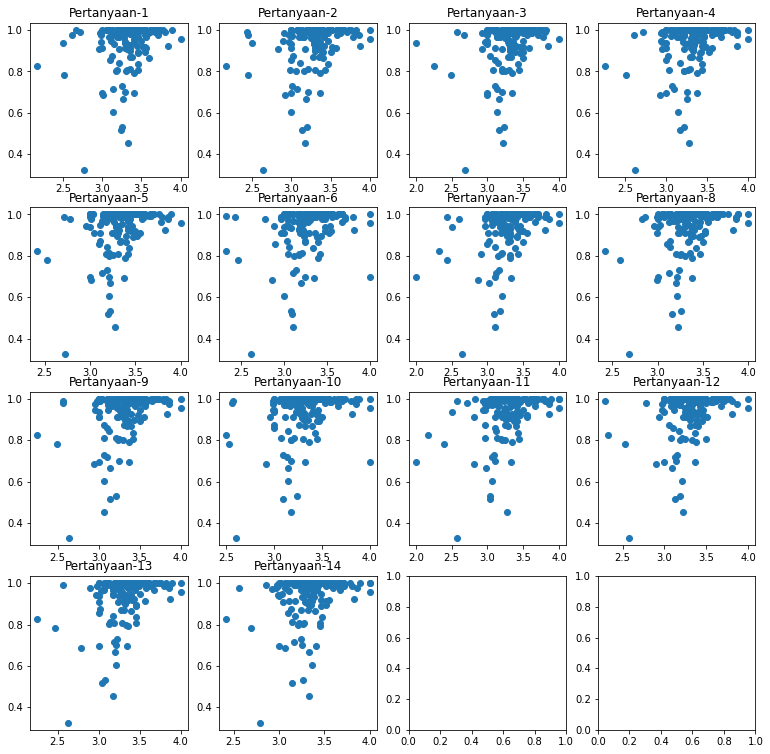

In [39]:
fig, ax = plt.subplots(4, 4, figsize=(13,13))

x = 0
y = 0

for i in range(0,14): 
    y = i % 4
    ax[x,y].set_title("Pertanyaan-" + str(i+1))
    ax[x,y].scatter(df4[i+1],df4["PROPORSI_LULUS"])
    print("Correlation Pertanyaan-" + str(i+1) + " : " + str(np.corrcoef(df4[i+1],df4["PROPORSI_LULUS"])[0,1]))
    if(y == 3):
        x += 1
        y = 0

Kualitas dosen tidak menunjukkan adanya linearitas terhadap performa mahasiswa

# Evaluating Models

Sampling Data

In [65]:
X = df3[['TOTAL_SKS', 'IPK', 'WAKTU_KULIAH']]
y = df3['HASIL']

<AxesSubplot:>

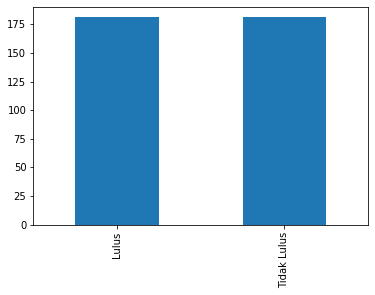

In [66]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y) 

y_rus.value_counts().plot(kind="bar")

<AxesSubplot:>

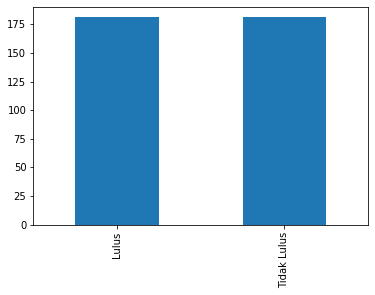

In [67]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y) 

y_rus.value_counts().plot(kind="bar")

In [68]:
np.random.seed(42)

In [70]:
# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

In [95]:
# spot-check algorithm

models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 0.9077441077441077 	 | cv_score_std: 0.03514287082327657
CART 	 | cv_score_mean: 0.8596632996632996 	 | cv_score_std: 0.03662606391123913
RF 	 | cv_score_mean: 0.8707744107744109 	 | cv_score_std: 0.028959674057057416
SVC 	 | cv_score_mean: 0.8117845117845117 	 | cv_score_std: 0.04750220091191488
KNN 	 | cv_score_mean: 0.8744781144781145 	 | cv_score_std: 0.043020448543065366


<AxesSubplot:>

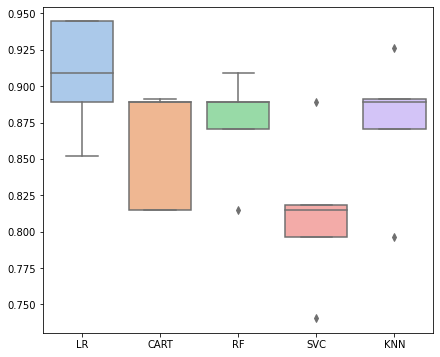

In [72]:
# boxplot comparing models

results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

# Train and Test the Model

In [73]:
# metrics for model evaluation

def evaluate_model(y_val, y_preds, model):
    print(f'{model} Evaluation')
    print('-'*70)
    print('accuracy score:', accuracy_score(y_val, y_preds))
    print('\nclassification report:\n', classification_report(y_val, y_preds))
    
    conf_matrix = confusion_matrix(y_val, y_preds)
    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(conf_matrix, square=True, annot=True, fmt='.3g', annot_kws={'fontsize': 13},cmap='Blues',
                     xticklabels=['Lulus Telat', 'Lulus Tepat Waktu', 'Tidak Lulus'], yticklabels=['Lulus Telat', 'Lulus Tepat Waktu', 'Tidak Lulus'])
    fig.suptitle('Confusion Matrix')
    ax.set_xlabel('Prediction Labels')
    ax.set_ylabel('True Labels')
    return ax

In [74]:
# train the model

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [75]:
# prediction on validation set

y_preds = model.predict(X_val)

LogisticRegression() Evaluation
----------------------------------------------------------------------
accuracy score: 0.9230769230769231

classification report:
               precision    recall  f1-score   support

       Lulus       0.92      0.94      0.93        48
 Tidak Lulus       0.93      0.91      0.92        43

    accuracy                           0.92        91
   macro avg       0.92      0.92      0.92        91
weighted avg       0.92      0.92      0.92        91



<AxesSubplot:xlabel='Prediction Labels', ylabel='True Labels'>

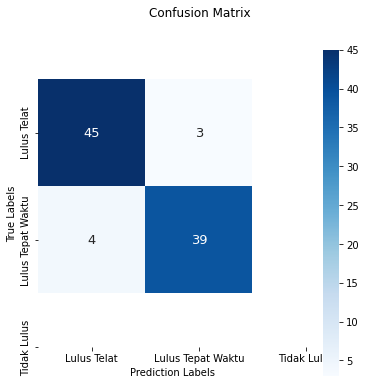

In [76]:
# model evaluation

evaluate_model(y_val, y_preds, model=model)

## Decision Tree Model

In [77]:
# check maximum depth of the tree

def checkMaxDepth(X, y):
    depth = np.arange(2, 21, 1)

    for i in depth:
        cart = DecisionTreeClassifier(max_depth=i)
        cart.fit(X_train, y_train)
        pred = cart.predict(X_val)
        accuracy = accuracy_score(y_val, pred)
        print(f'max_depth: {i} \t | accuracy score: {accuracy}')

checkMaxDepth(X=X_train, y=y_train)

max_depth: 2 	 | accuracy score: 0.9230769230769231
max_depth: 3 	 | accuracy score: 0.9230769230769231
max_depth: 4 	 | accuracy score: 0.9230769230769231
max_depth: 5 	 | accuracy score: 0.9230769230769231
max_depth: 6 	 | accuracy score: 0.9340659340659341
max_depth: 7 	 | accuracy score: 0.9340659340659341
max_depth: 8 	 | accuracy score: 0.9120879120879121
max_depth: 9 	 | accuracy score: 0.9010989010989011
max_depth: 10 	 | accuracy score: 0.9120879120879121
max_depth: 11 	 | accuracy score: 0.9120879120879121
max_depth: 12 	 | accuracy score: 0.9010989010989011
max_depth: 13 	 | accuracy score: 0.9120879120879121
max_depth: 14 	 | accuracy score: 0.9120879120879121
max_depth: 15 	 | accuracy score: 0.9120879120879121
max_depth: 16 	 | accuracy score: 0.9120879120879121
max_depth: 17 	 | accuracy score: 0.9010989010989011
max_depth: 18 	 | accuracy score: 0.9120879120879121
max_depth: 19 	 | accuracy score: 0.9120879120879121
max_depth: 20 	 | accuracy score: 0.9120879120879121


In [78]:
# train the model

cart = DecisionTreeClassifier(max_depth=7)
cart.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [79]:
# prediction on validation set

y_preds = cart.predict(X_val)

# evaluating accuracy

print("accuracy score:", accuracy_score(y_val, y_preds))

accuracy score: 0.9340659340659341


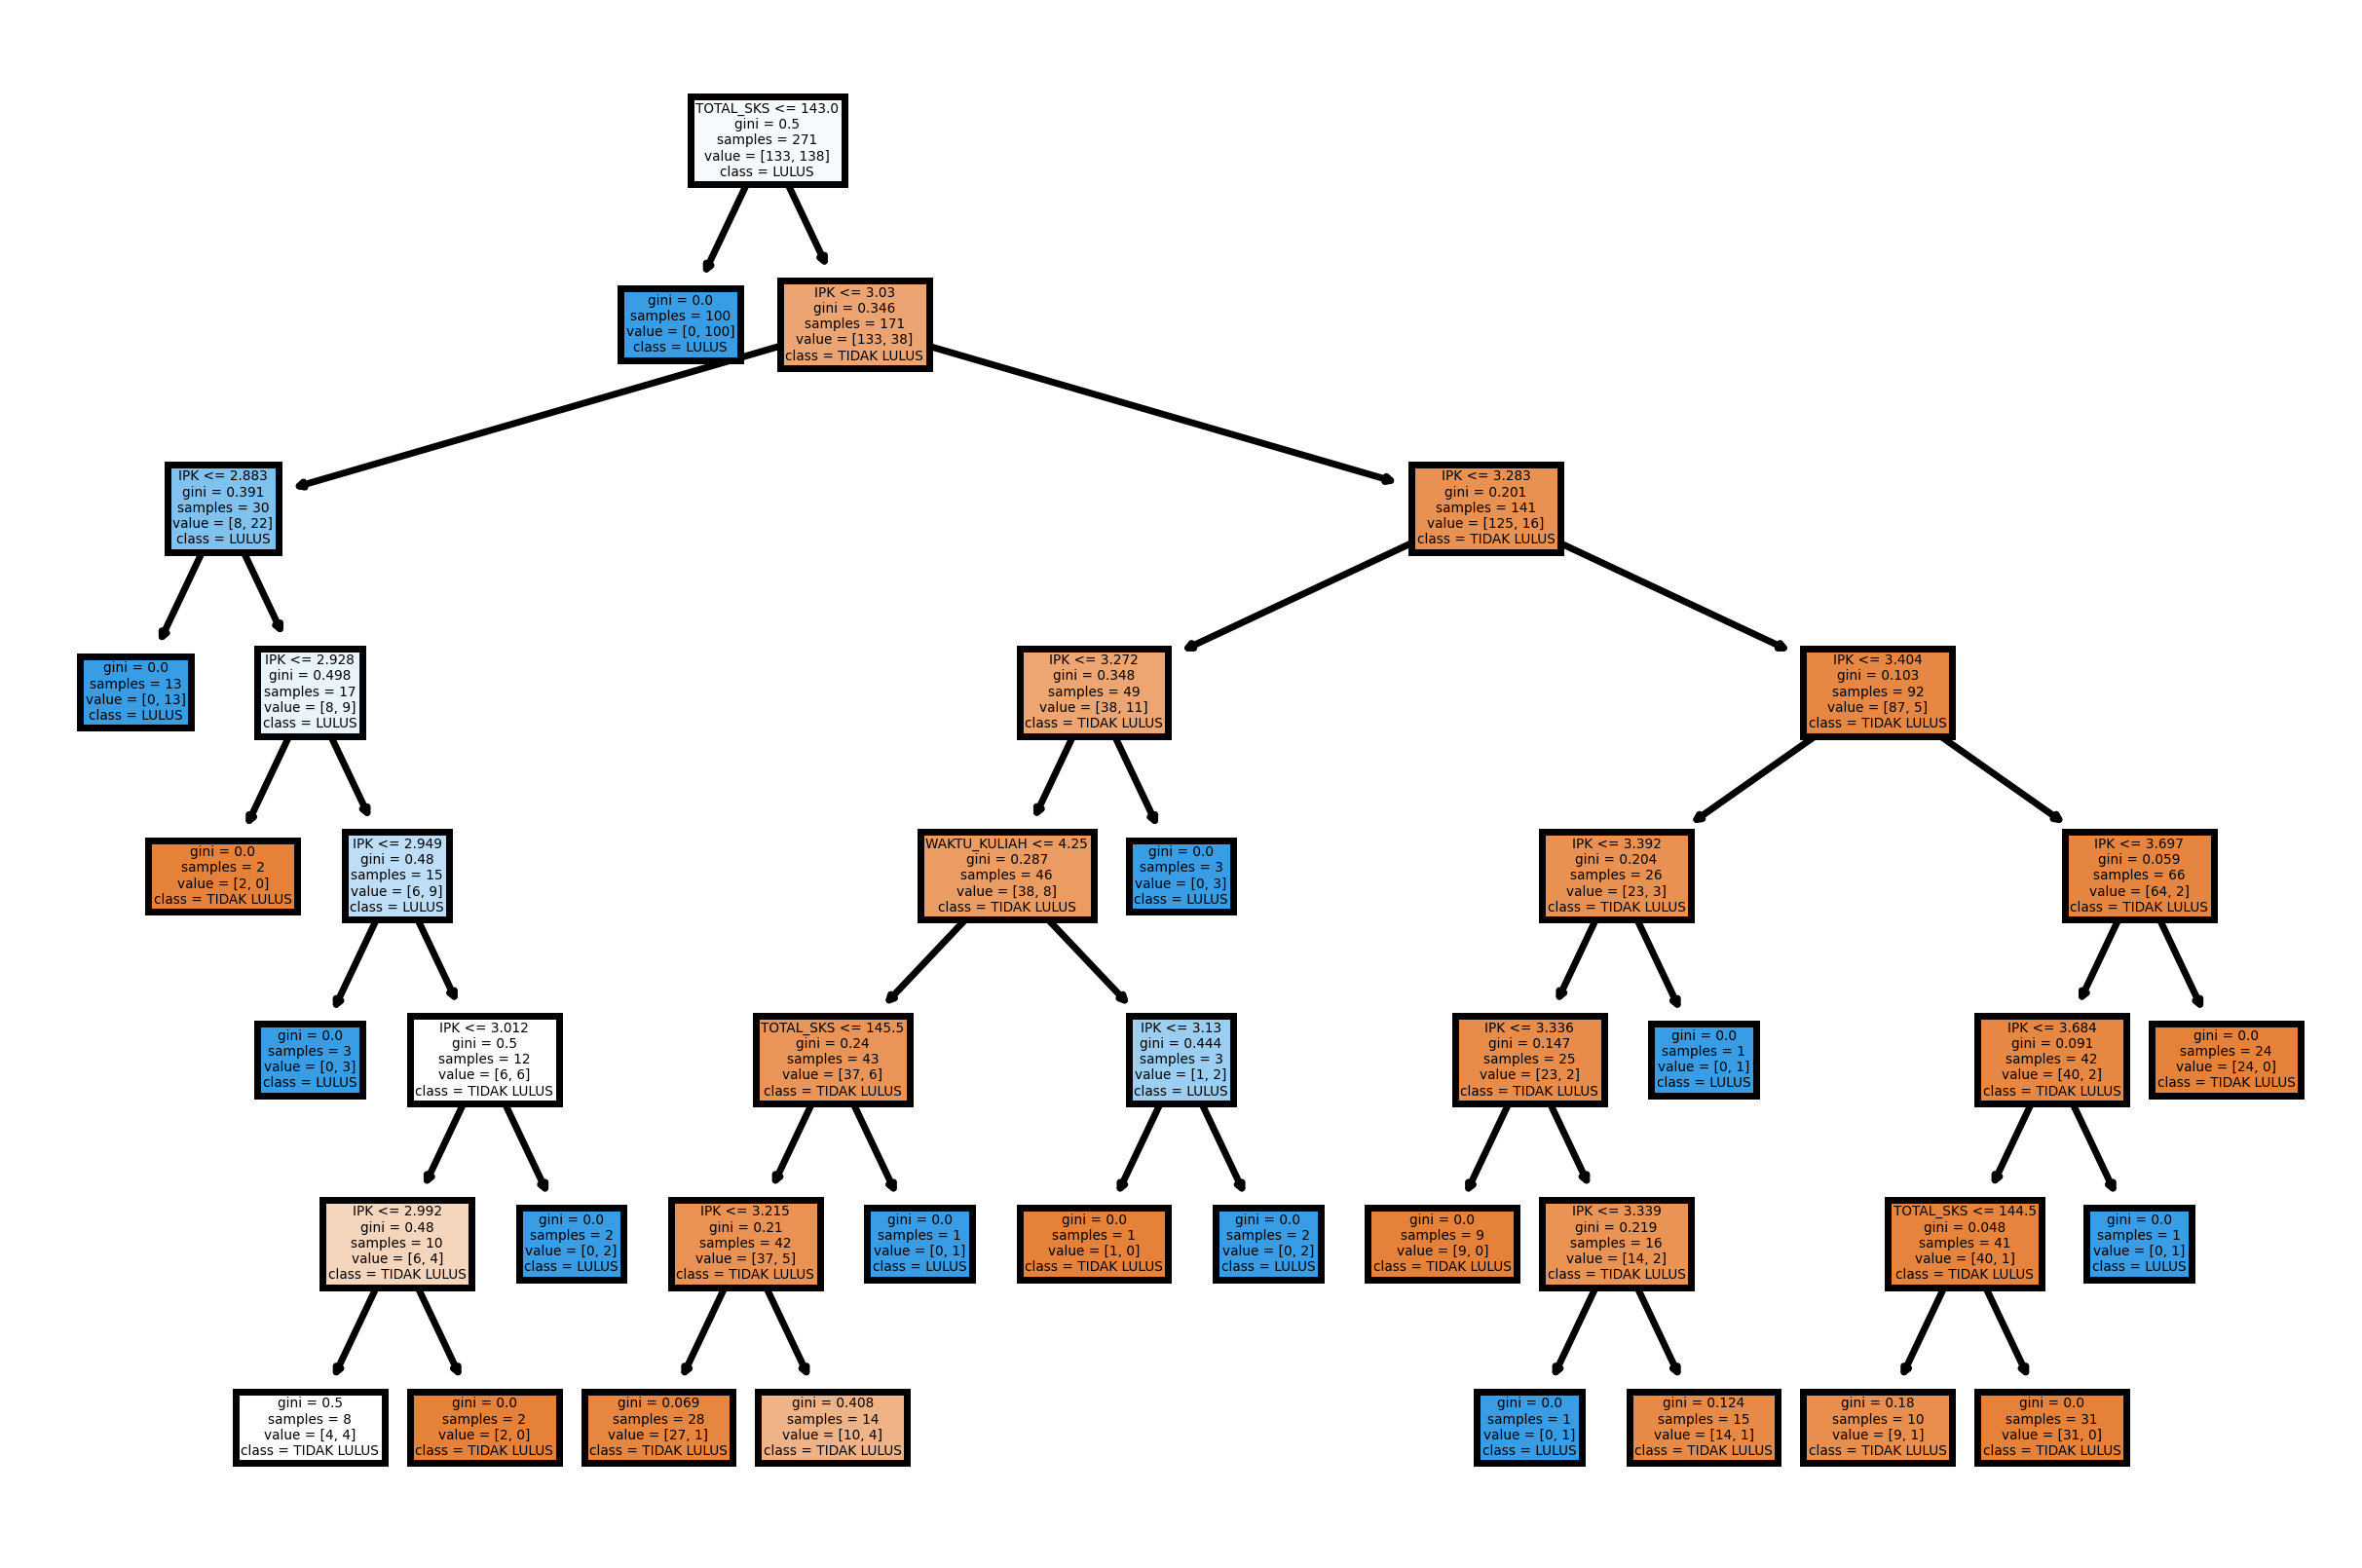

In [80]:
# plot tree

plt.figure(dpi=500)

_ = plot_tree(cart, feature_names=X.columns, class_names=['TIDAK LULUS', 'LULUS'], filled=True)

DecisionTreeClassifier(max_depth=7) Evaluation
----------------------------------------------------------------------
accuracy score: 0.9340659340659341

classification report:
               precision    recall  f1-score   support

       Lulus       0.94      0.94      0.94        48
 Tidak Lulus       0.93      0.93      0.93        43

    accuracy                           0.93        91
   macro avg       0.93      0.93      0.93        91
weighted avg       0.93      0.93      0.93        91



<AxesSubplot:xlabel='Prediction Labels', ylabel='True Labels'>

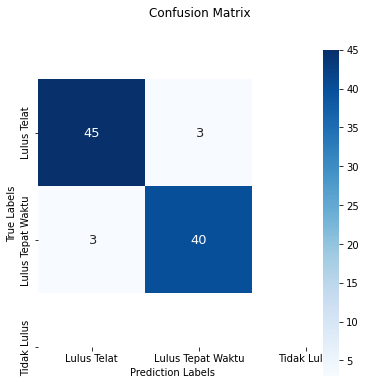

In [81]:
# decision tree model evaluation

evaluate_model(y_val=y_val, y_preds=y_preds, model=cart)

In [82]:
# check maximum depth of tree with full dataset

def checkMaxDepth(X, y):
    depth = np.arange(2, 21, 1)

    for i in depth:
        cart = DecisionTreeClassifier(max_depth=i)
        cart.fit(X_train, y_train)
        pred = cart.predict(X_val)
        accuracy = accuracy_score(y_val, pred)
        print(f'max_depth: {i} \t | accuracy score: {accuracy}')
        

checkMaxDepth(X=X, y=y)

max_depth: 2 	 | accuracy score: 0.9230769230769231
max_depth: 3 	 | accuracy score: 0.9230769230769231
max_depth: 4 	 | accuracy score: 0.9230769230769231
max_depth: 5 	 | accuracy score: 0.9230769230769231
max_depth: 6 	 | accuracy score: 0.9340659340659341
max_depth: 7 	 | accuracy score: 0.9340659340659341
max_depth: 8 	 | accuracy score: 0.9120879120879121
max_depth: 9 	 | accuracy score: 0.9230769230769231
max_depth: 10 	 | accuracy score: 0.9120879120879121
max_depth: 11 	 | accuracy score: 0.9120879120879121
max_depth: 12 	 | accuracy score: 0.9120879120879121
max_depth: 13 	 | accuracy score: 0.9120879120879121
max_depth: 14 	 | accuracy score: 0.9010989010989011
max_depth: 15 	 | accuracy score: 0.9120879120879121
max_depth: 16 	 | accuracy score: 0.9120879120879121
max_depth: 17 	 | accuracy score: 0.9120879120879121
max_depth: 18 	 | accuracy score: 0.9010989010989011
max_depth: 19 	 | accuracy score: 0.9010989010989011
max_depth: 20 	 | accuracy score: 0.9010989010989011


## K-Means

Accuracy :  0.4142857142857143


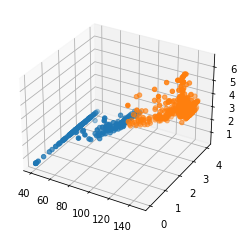

In [91]:
from mpl_toolkits import mplot3d

km = KMeans(n_clusters=2)
y_pred = km.fit_predict(X)
df3['CLUSTER']  = y_pred

dfc_1 = df3[df3.CLUSTER == 0]
dfc_2 = df3[df3.CLUSTER == 1]
# dfc_3 = df3[df3.CLUSTER == 2]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(dfc_1["TOTAL_SKS"], dfc_1["IPK"], dfc_1["WAKTU_KULIAH"])
ax.scatter3D(dfc_2["TOTAL_SKS"], dfc_2["IPK"], dfc_2["WAKTU_KULIAH"])
# ax.scatter3D( dfc_3["TOTAL_SKS"], dfc_3["IPK"], dfc_3["WAKTU_KULIAH"])
# plt.scatter(dfc_2["WAKTU_KULIAH"], dfc_2["IPK"])
# plt.scatter(dfc_3["WAKTU_KULIAH"], dfc_3["IPK"])

# 0 : Tidak Lulus
# 1 : Lulus Telat
# 2 : Lulus Tepat Waktu

total_right = 0 
total = 0 
for i in df3.index:
    if df3.at[i, 'CLUSTER'] == 1 and df3.at[i, "HASIL"] == "Tidak Lulus":
        total_right += 1
    if df3.at[i, 'CLUSTER'] == 0 and df3.at[i, "HASIL"] == "Lulus":
        total_right += 1
    # if df3.at[i, 'CLUSTER'] == 2 and df3.at[i, "HASIL"] == "Lulus Tepat Waktu":
    #     total_right += 1
    total += 1

print("Accuracy : ", total_right/total )

In [85]:
# train the model

km = KMeans()

km.fit(X_train, y_train)

KMeans()

In [86]:
# prediction on validation set

y_preds = km.predict(X_val)

KMeans() Evaluation
----------------------------------------------------------------------
accuracy score: 0.9230769230769231

classification report:
               precision    recall  f1-score   support

       Lulus       0.90      0.96      0.93        48
 Tidak Lulus       0.95      0.88      0.92        43

    accuracy                           0.92        91
   macro avg       0.93      0.92      0.92        91
weighted avg       0.92      0.92      0.92        91



<AxesSubplot:xlabel='Prediction Labels', ylabel='True Labels'>

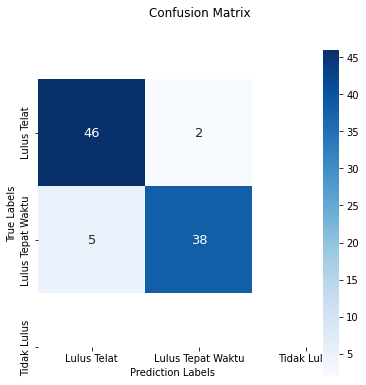

In [90]:
evaluate_model(y_val, y_preds, km)

## KNN (K Nearest Neighbors)

In [87]:
# train the model

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [88]:
# prediction on validation set

y_preds = knn.predict(X_val)

KNeighborsClassifier() Evaluation
----------------------------------------------------------------------
accuracy score: 0.9230769230769231

classification report:
               precision    recall  f1-score   support

       Lulus       0.90      0.96      0.93        48
 Tidak Lulus       0.95      0.88      0.92        43

    accuracy                           0.92        91
   macro avg       0.93      0.92      0.92        91
weighted avg       0.92      0.92      0.92        91



<AxesSubplot:xlabel='Prediction Labels', ylabel='True Labels'>

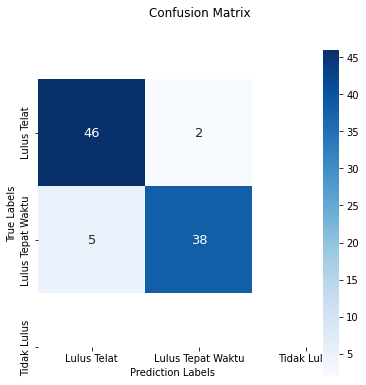

In [89]:
# knn model evaluation

evaluate_model(y_val, y_preds, knn)

## SVM (Support Vector Machine)

In [92]:
# train model

svc = SVC()

svc.fit(X_train, y_train)

SVC()

In [93]:
# prediction on validation set

y_preds = svc.predict(X_val)

SVC() Evaluation
----------------------------------------------------------------------
accuracy score: 0.8681318681318682

classification report:
               precision    recall  f1-score   support

       Lulus       0.80      1.00      0.89        48
 Tidak Lulus       1.00      0.72      0.84        43

    accuracy                           0.87        91
   macro avg       0.90      0.86      0.86        91
weighted avg       0.89      0.87      0.86        91



<AxesSubplot:xlabel='Prediction Labels', ylabel='True Labels'>

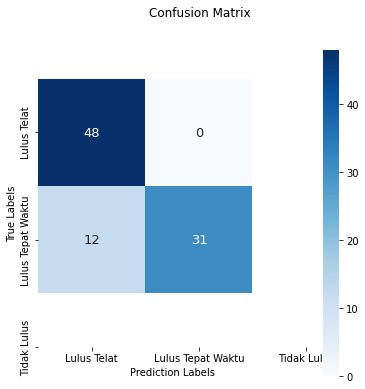

In [94]:
# svm evaluation

evaluate_model(y_val, y_preds, svc)